# 3.2.2 Hyperparameter Tuning: GNN Variant



In this notebook we look at the hyperparameter sensitivity of our GraphSAGE model and then try to find the best hyperparameter combination with a bayesian optimization:

- Early Stopping Patience
- Learning Rate
- Dropout Rate
- Weight Decay
- Bayesian Optimization

### Dataset Configuration

In [18]:
data_name = 'chrome-run-01'
with_centrality_metrics = False

### Set Up

In [19]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import torch
import sys
import os
import pandas as pd
model_definition_path = os.path.join('..', 'models', 'definitions')
models_path = os.path.join('..', 'src', 'models')
data_path = os.path.join('..', 'src', 'data')
sys.path.append(model_definition_path)
sys.path.append(models_path)
sys.path.append(data_path)
import gnn
import evaluate_model
import train_model
from skopt.space import Real

We set the training logs:

In [58]:
csv_file_hyperparameters = os.path.join('..', 'reports', 'variant', 'hyperparameter_log.csv')
csv_file_grid_search = os.path.join('..', 'reports', 'variant', 'grid_search_log.csv')
csv_file_bayesian_opt = os.path.join('..', 'reports', 'variant', 'bayesian_opt_log.csv')

We will be using the dataset without the centrality metrics:

In [22]:
# Load data
if with_centrality_metrics:
    data_name = f"{data_name}-with-centrality-metrics"
else:
    data_name = f"{data_name}-without-centrality-metrics"
    
data_path = os.path.join('..', 'data', 'processed', f'{data_name}.pt')
data = torch.load(data_path)

print(data)

Data(x=[25338, 33], edge_index=[2, 131846], num_nodes=25338, y=[25338], train_mask=[25338], val_mask=[25338], test_mask=[25338])


We initalise our baseline GraphSAGE hyperparameters:

In [23]:
# Hyperparameters
hidden_channels = 64
num_epochs = 1000

# Calculating class weights
labels = data.y[data.train_mask]
class_counts = labels.bincount()
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()  # Normalize weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Loss function
cross_entropy = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

We experiment with the hyperparameters to find values with a stable training process:

In [24]:
learning_rate = 0.001
weight_decay = 1e-4
dropout_rate = 0.1

model_experiment=  [{'model_name': 'GraphSAGE Experiment', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy}]


Training GraphSAGE Experiment model (1/1) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/1, Model: GraphSAGE Experiment, Epoch: 50, Loss: 0.4064, Val Loss: 0.4118, Val Accuracy: 0.7927, Val Precision: 0.6419, Val Recall: 0.8763, Val F1: 0.7410
Run: 1/1, Model: GraphSAGE Experiment, Epoch: 100, Loss: 0.3768, Val Loss: 0.3758, Val Accuracy: 0.8062, Val Precision: 0.6634, Val Recall: 0.8670, Val F1: 0.7516
Run: 1/1, Model: GraphSAGE Experiment, Epoch: 150, Loss: 0.3476, Val Loss: 0.3450, Val Accuracy: 0.8180, Val Precision: 0.6752, Val Recall: 0.8903, Val F1: 0.7680
Run: 1/1, Model: GraphSAGE Experiment, Epoch: 200, Loss: 0.3252, Val Loss: 0.3239, Val Accuracy: 0.8220, Val Precision: 0.6753, Val Recall: 0.9125, Val F1: 0.7762
Run: 1/1, Model: GraphSAGE Experiment, Epoch: 250, Loss: 0.3106, Val Loss: 0.3175, Val Accuracy: 0.8354, Val Precision: 0.6978, Val Recall: 0.9055, Val F1: 0.7882
Run: 1/1, Model: GraphSAGE Experiment, Epoch: 300, Loss: 0.3010, Val Loss: 0.3018, Val 

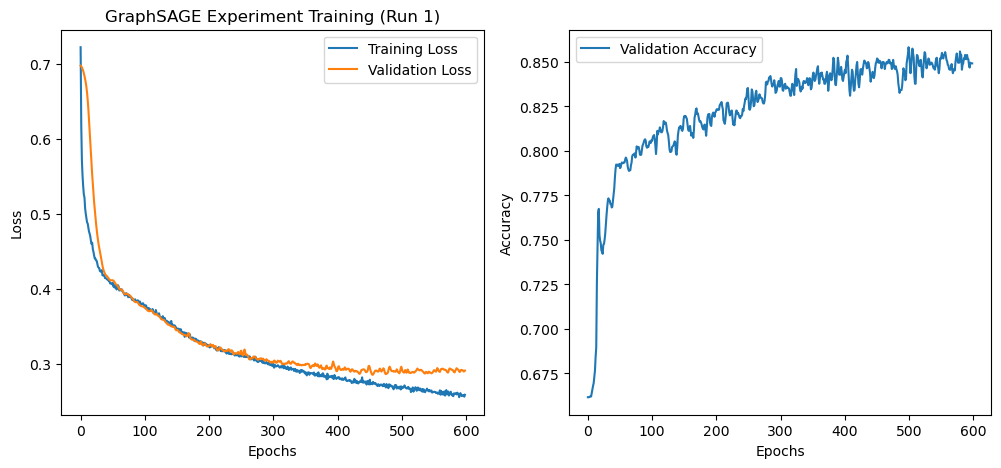


Successfully trained GraphSAGE Experiment model (1/1) on chrome-run-01-without-centrality-metrics dataset


In [25]:
trained_model_experiment =  train_model.train_validate(model_experiment, csv_file_hyperparameters, num_runs=1, early_stopping_patience=100)

### Early Stopping Patience

In [26]:
learning_rate = 0.001
weight_decay = 1e-4
dropout_rate = 0.1

model_early_stop =  [{'model_name': 'GraphSAGE Early Stop', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy}]


Training GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 50, Loss: 0.4091, Val Loss: 0.4110, Val Accuracy: 0.7793, Val Precision: 0.6202, Val Recall: 0.8973, Val F1: 0.7334
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 100, Loss: 0.3845, Val Loss: 0.3838, Val Accuracy: 0.7904, Val Precision: 0.6352, Val Recall: 0.8938, Val F1: 0.7426
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 150, Loss: 0.3628, Val Loss: 0.3639, Val Accuracy: 0.8117, Val Precision: 0.6721, Val Recall: 0.8658, Val F1: 0.7568
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 200, Loss: 0.3400, Val Loss: 0.3381, Val Accuracy: 0.8267, Val Precision: 0.6921, Val Recall: 0.8786, Val F1: 0.7743
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 250, Loss: 0.3232, Val Loss: 0.3202, Val Accuracy: 0.8330, Val Precision: 0.6917, Val Recall: 0.9137, Val F1: 0.7873
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 300, Loss: 0.3061, Val Loss: 0.3099, Val 

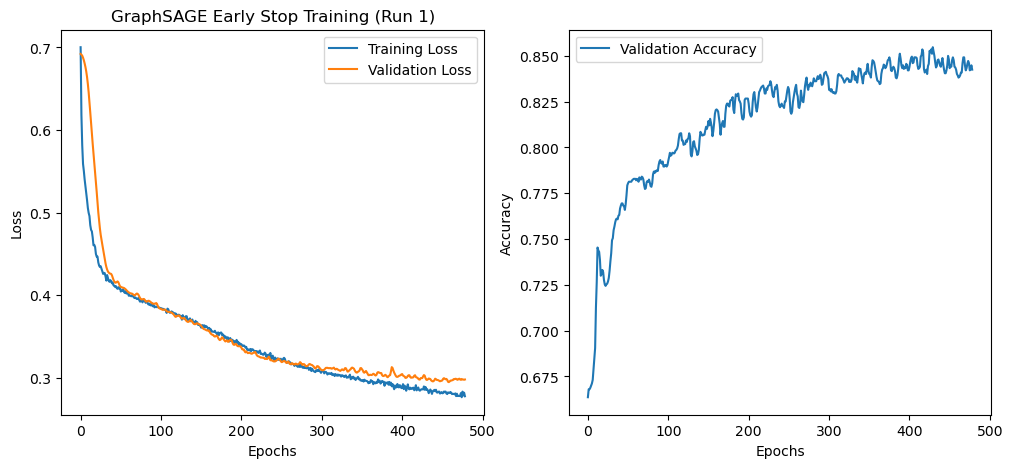


Successfully trained GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 50, Loss: 0.4027, Val Loss: 0.4065, Val Accuracy: 0.7892, Val Precision: 0.6345, Val Recall: 0.8891, Val F1: 0.7405
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 100, Loss: 0.3776, Val Loss: 0.3773, Val Accuracy: 0.8034, Val Precision: 0.6560, Val Recall: 0.8810, Val F1: 0.7520
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 150, Loss: 0.3532, Val Loss: 0.3516, Val Accuracy: 0.8066, Val Precision: 0.6533, Val Recall: 0.9125, Val F1: 0.7614
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 200, Loss: 0.3285, Val Loss: 0.3322, Val Accuracy: 0.8330, Val Precision: 0.7047, Val Recall: 0.8716, Val F1: 0.7793
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 250, Loss: 0.3141, Val Loss: 0.3103, Val Accuracy: 0.8306, Val Precision: 0.6914, Val Recall: 0.9

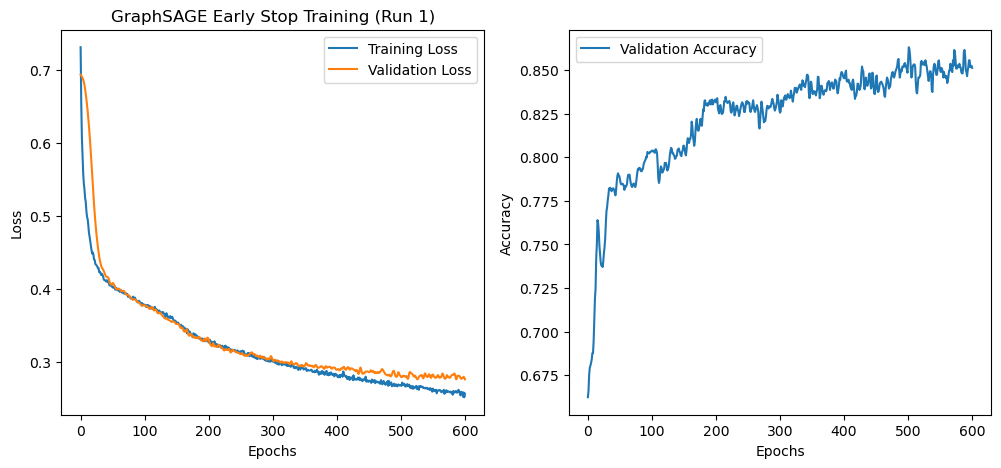


Successfully trained GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 50, Loss: 0.3994, Val Loss: 0.4035, Val Accuracy: 0.7888, Val Precision: 0.6351, Val Recall: 0.8833, Val F1: 0.7389
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 100, Loss: 0.3799, Val Loss: 0.3713, Val Accuracy: 0.8066, Val Precision: 0.6631, Val Recall: 0.8705, Val F1: 0.7528
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 150, Loss: 0.3461, Val Loss: 0.3399, Val Accuracy: 0.8275, Val Precision: 0.6934, Val Recall: 0.8786, Val F1: 0.7751
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 200, Loss: 0.3290, Val Loss: 0.3261, Val Accuracy: 0.8235, Val Precision: 0.6740, Val Recall: 0.9265, Val F1: 0.7803
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 250, Loss: 0.3145, Val Loss: 0.3174, Val Accuracy: 0.8247, Val Precision: 0.6788, Val Recall: 0.9

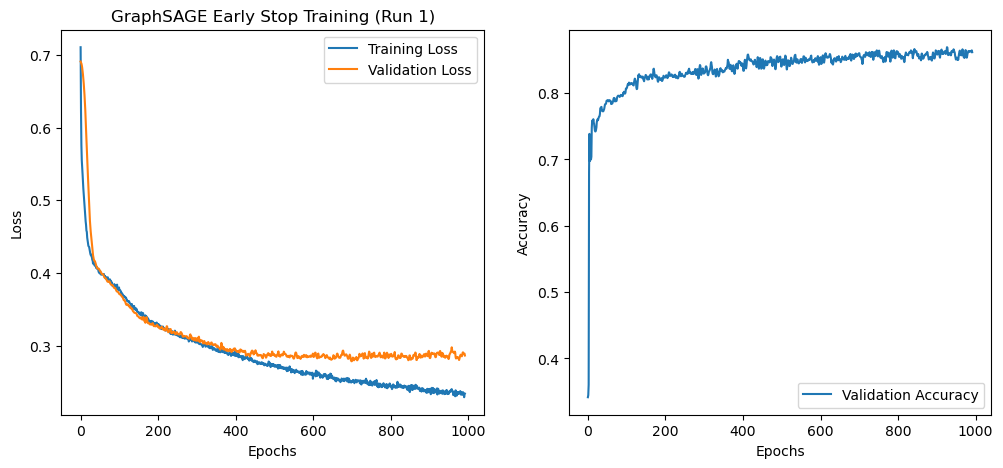


Successfully trained GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset...

Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 50, Loss: 0.4034, Val Loss: 0.4080, Val Accuracy: 0.7939, Val Precision: 0.6460, Val Recall: 0.8646, Val F1: 0.7395
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 100, Loss: 0.3755, Val Loss: 0.3811, Val Accuracy: 0.8101, Val Precision: 0.6808, Val Recall: 0.8261, Val F1: 0.7464
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 150, Loss: 0.3424, Val Loss: 0.3422, Val Accuracy: 0.8180, Val Precision: 0.6771, Val Recall: 0.8833, Val F1: 0.7666
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 200, Loss: 0.3287, Val Loss: 0.3238, Val Accuracy: 0.8223, Val Precision: 0.6753, Val Recall: 0.9148, Val F1: 0.7770
Run: 1/1, Model: GraphSAGE Early Stop, Epoch: 250, Loss: 0.3146, Val Loss: 0.3118, Val Accuracy: 0.8251, Val Precision: 0.6788, Val Recall: 0.9

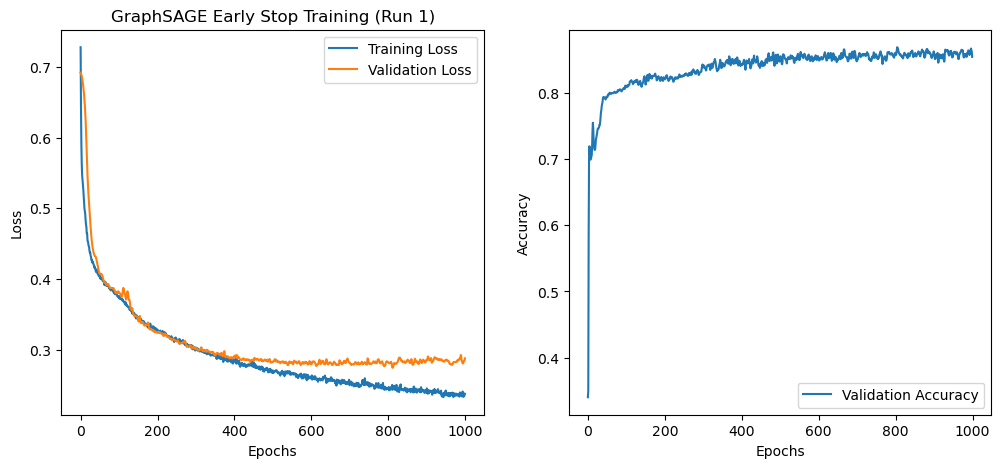


Successfully trained GraphSAGE Early Stop model (1/1) on chrome-run-01-without-centrality-metrics dataset


In [27]:
model_early_stop_50 =  train_model.train_validate(model_early_stop, csv_file_hyperparameters, num_runs=1, early_stopping_patience=50, print_epochs=False)
model_early_stop_100 =  train_model.train_validate(model_early_stop, csv_file_hyperparameters, num_runs=1, early_stopping_patience=100, print_epochs=False)
model_early_stop_150 =  train_model.train_validate(model_early_stop, csv_file_hyperparameters, num_runs=1, early_stopping_patience=150, print_epochs=False)
model_early_stop_200 = train_model.train_validate(model_early_stop, csv_file_hyperparameters, num_runs=1, early_stopping_patience=200, print_epochs=False)

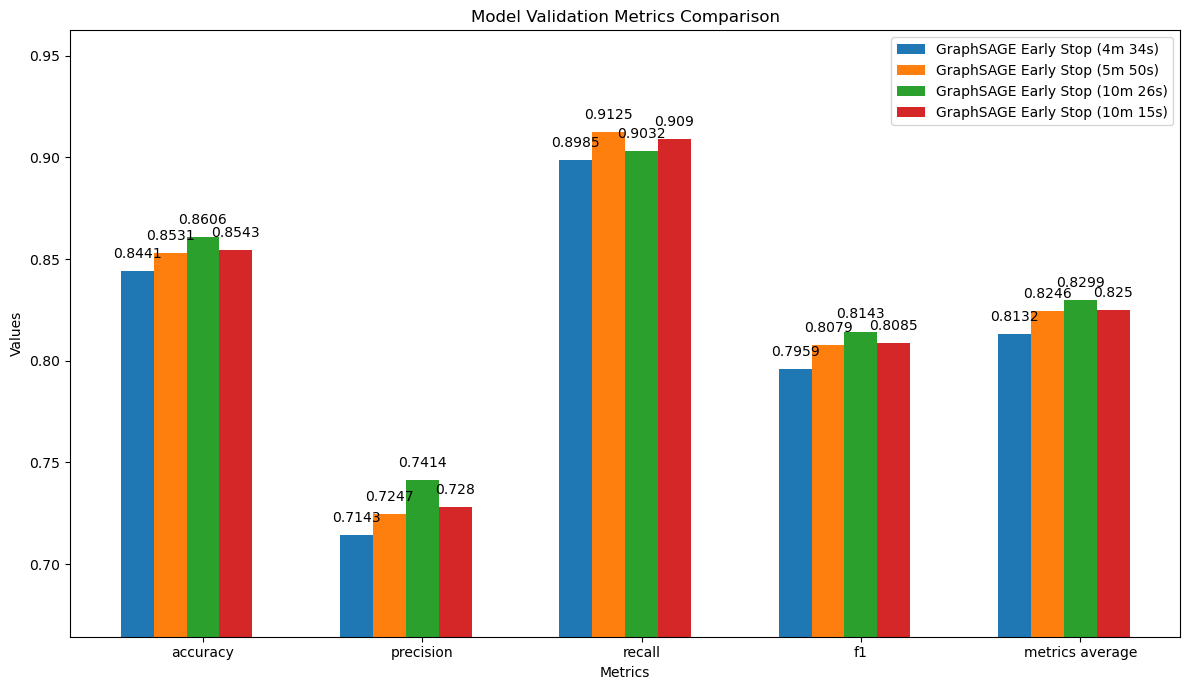

Standard Deviation for Accuracy: 0.006
Standard Deviation for Precision: 0.010
Standard Deviation for Recall: 0.005
Standard Deviation for F1: 0.007


In [28]:
evaluate_model.plot_val_metrics(model_early_stop_50 + model_early_stop_100 + model_early_stop_150 + model_early_stop_200)

### Learning Rate

In [29]:
weight_decay = 1e-4
dropout_rate = 0.1

models_learning_rates = [
    {'model_name': 'GraphSAGE LR 0.0005', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': 0.0005, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE LR 0.001', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': 0.001, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE LR 0.005', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': 0.005, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE LR 0.01', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': 0.01, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE LR 0.05', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': 0.05, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy},
]


Training GraphSAGE LR 0.0005 model (1/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE LR 0.0005: 100%|██████████| 1000/1000 [10:33<00:00,  1.58it/s]


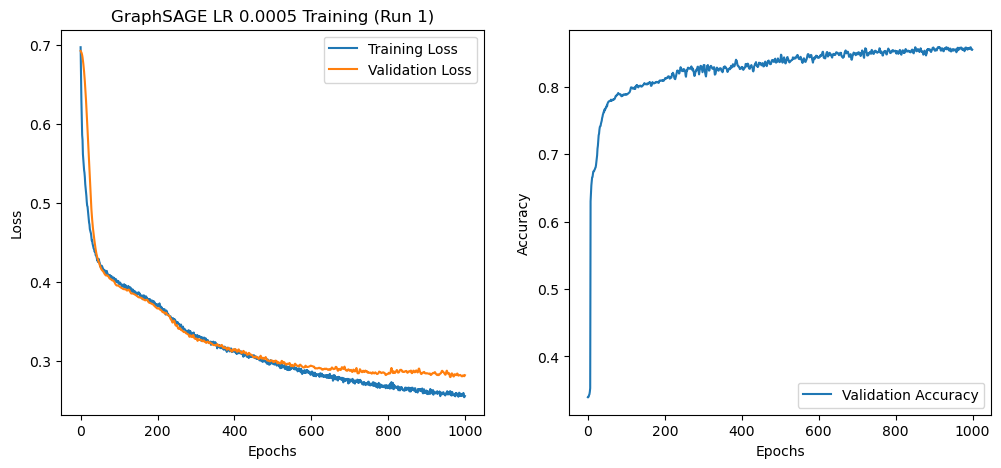


Successfully trained GraphSAGE LR 0.0005 model (1/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE LR 0.001 model (2/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE LR 0.001 (Early stop):  97%|█████████▋| 968/1000 [09:26<00:18,  1.71it/s]


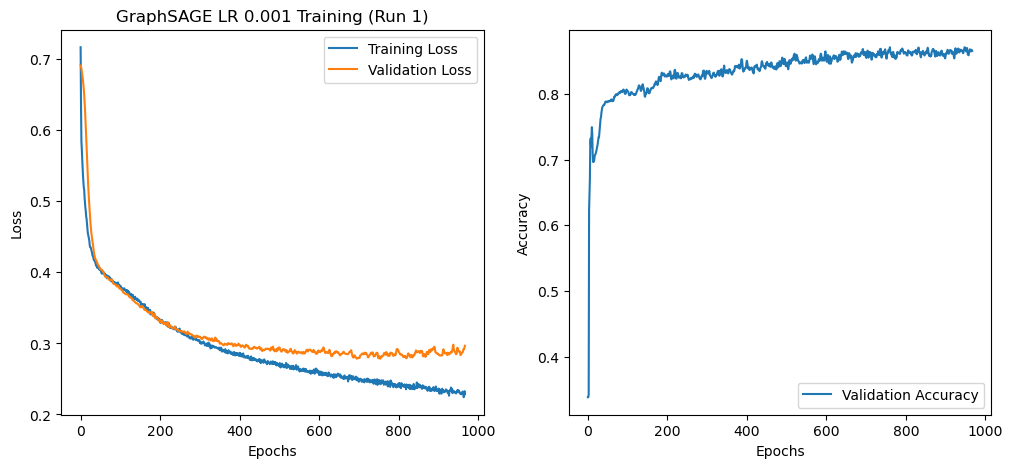


Successfully trained GraphSAGE LR 0.001 model (2/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE LR 0.005 model (3/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE LR 0.005 (Early stop):  64%|██████▍   | 641/1000 [06:10<03:27,  1.73it/s]


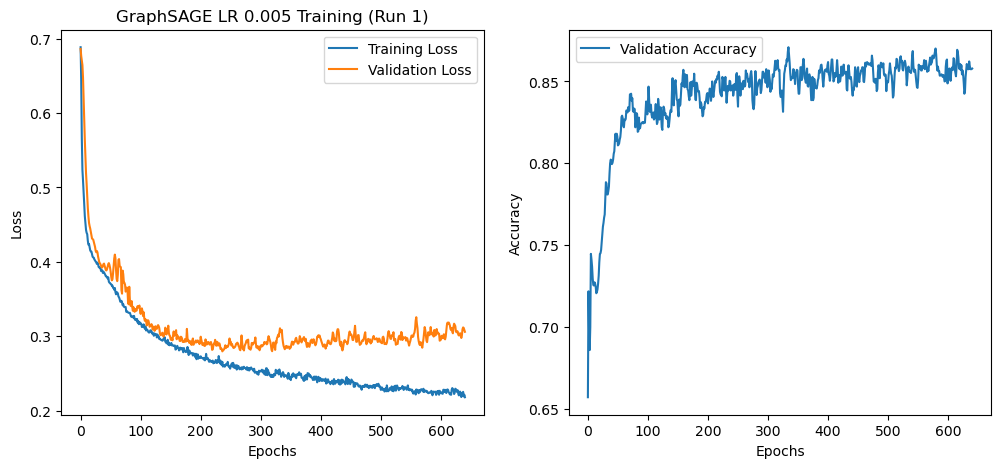


Successfully trained GraphSAGE LR 0.005 model (3/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE LR 0.01 model (4/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE LR 0.01 (Early stop):  34%|███▍      | 341/1000 [03:13<06:13,  1.76it/s]


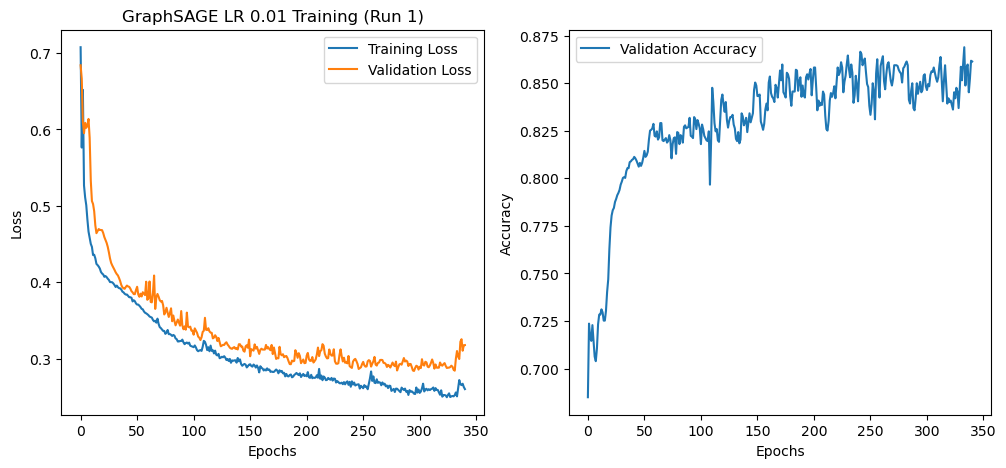


Successfully trained GraphSAGE LR 0.01 model (4/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE LR 0.05 model (5/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE LR 0.05 (Early stop):  47%|████▋     | 468/1000 [04:54<05:35,  1.59it/s]


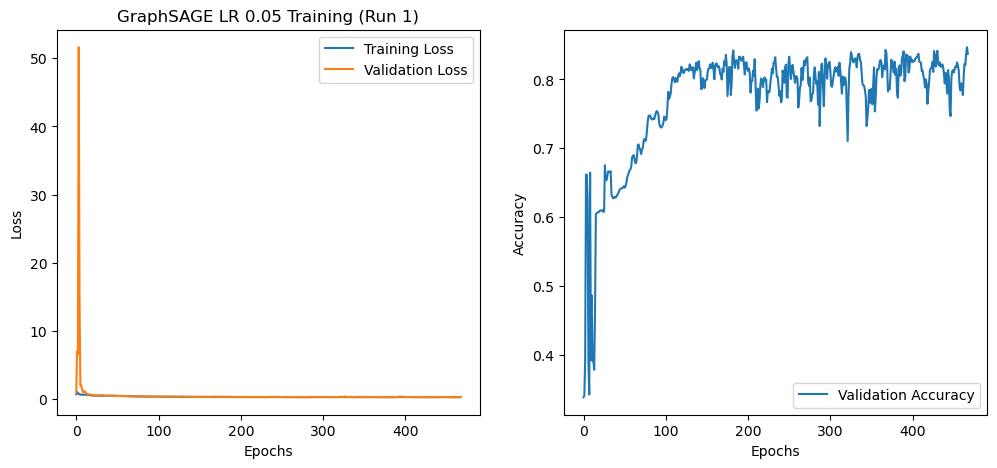


Successfully trained GraphSAGE LR 0.05 model (5/5) on chrome-run-01-without-centrality-metrics dataset


In [30]:
trained_models_learning_rates = train_model.train_validate(models_learning_rates, csv_file_hyperparameters, num_runs=1, print_epochs=False)

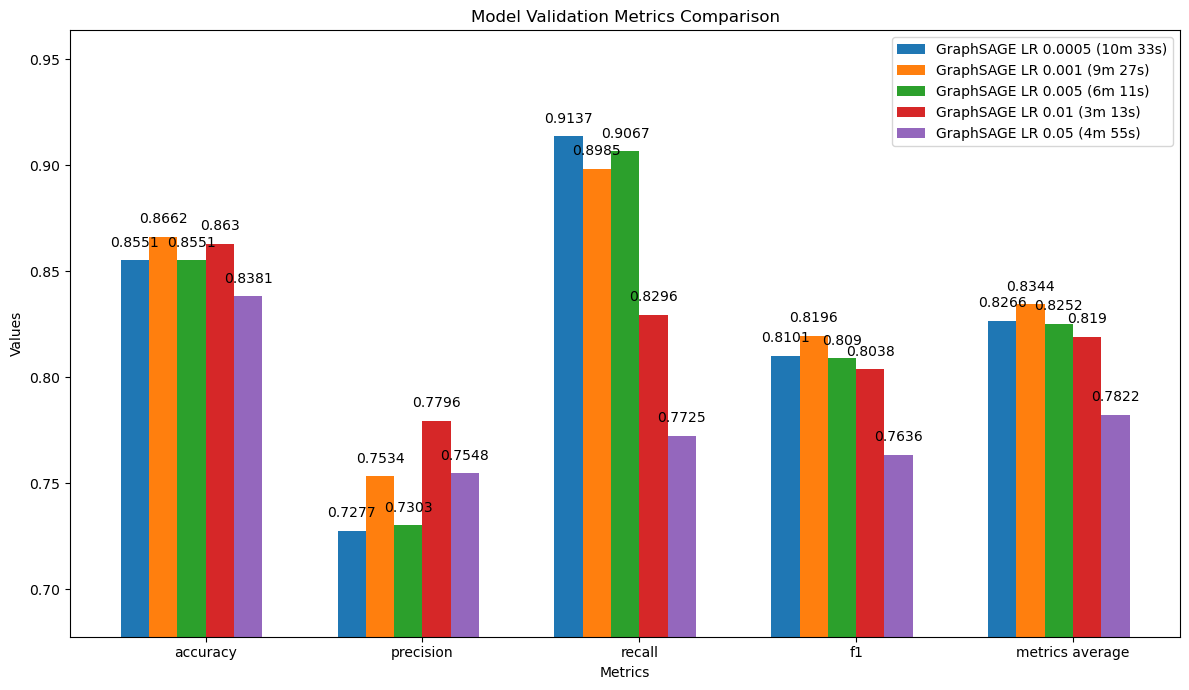

Standard Deviation for Accuracy: 0.010
Standard Deviation for Precision: 0.019
Standard Deviation for Recall: 0.055
Standard Deviation for F1: 0.020


In [31]:
evaluate_model.plot_val_metrics(trained_models_learning_rates)

### Dropout Rate

In [32]:
learning_rate = 0.001
weight_decay = 1e-4

models_dropout_rates = [
    {'model_name': 'GraphSAGE DR 0.0', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': 0.0, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE DR 0.1', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': 0.1, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE DR 0.3', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': 0.3, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE DR 0.5', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': 0.5, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE DR 0.7', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': 0.7, 'criterion': cross_entropy}
]


Training GraphSAGE DR 0.0 model (1/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE DR 0.0 (Early stop):  42%|████▏     | 422/1000 [03:17<04:30,  2.14it/s]


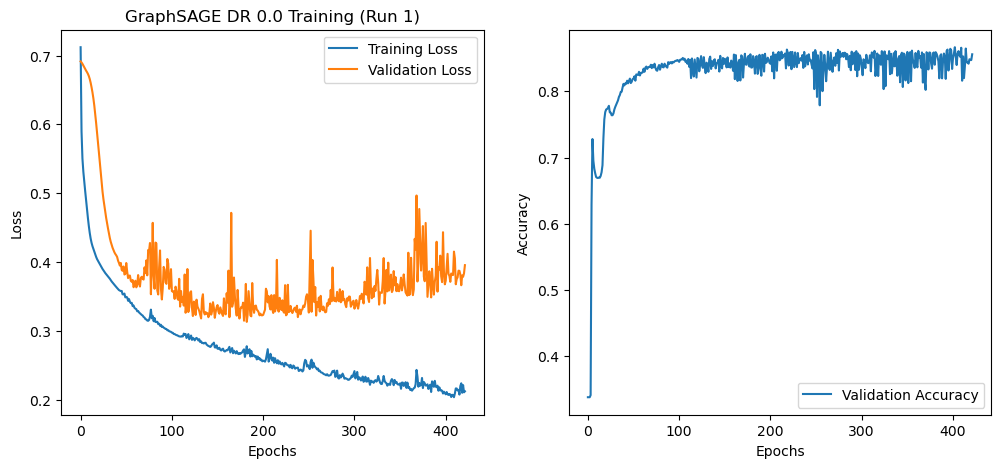


Successfully trained GraphSAGE DR 0.0 model (1/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE DR 0.1 model (2/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE DR 0.1 (Early stop):  70%|███████   | 700/1000 [06:56<02:58,  1.68it/s]


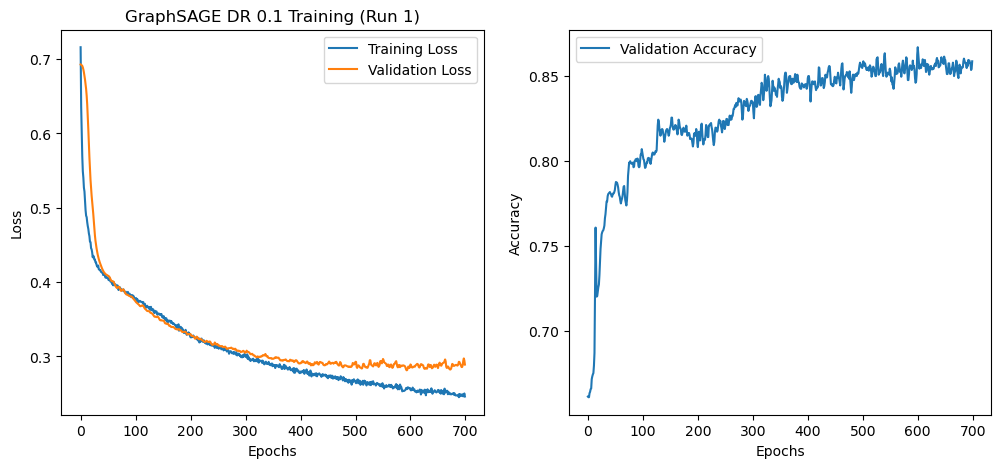


Successfully trained GraphSAGE DR 0.1 model (2/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE DR 0.3 model (3/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE DR 0.3 (Early stop):  40%|███▉      | 399/1000 [03:57<05:57,  1.68it/s]


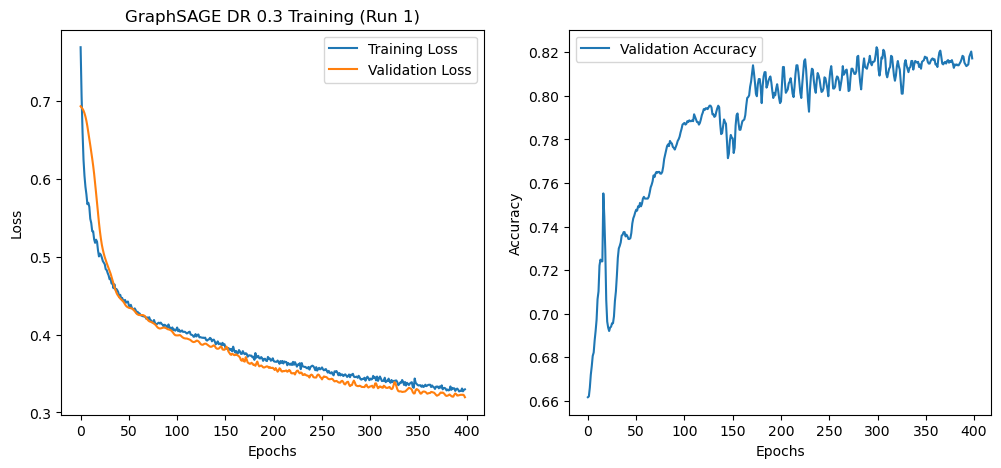


Successfully trained GraphSAGE DR 0.3 model (3/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE DR 0.5 model (4/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE DR 0.5 (Early stop):  55%|█████▍    | 548/1000 [05:27<04:29,  1.67it/s]


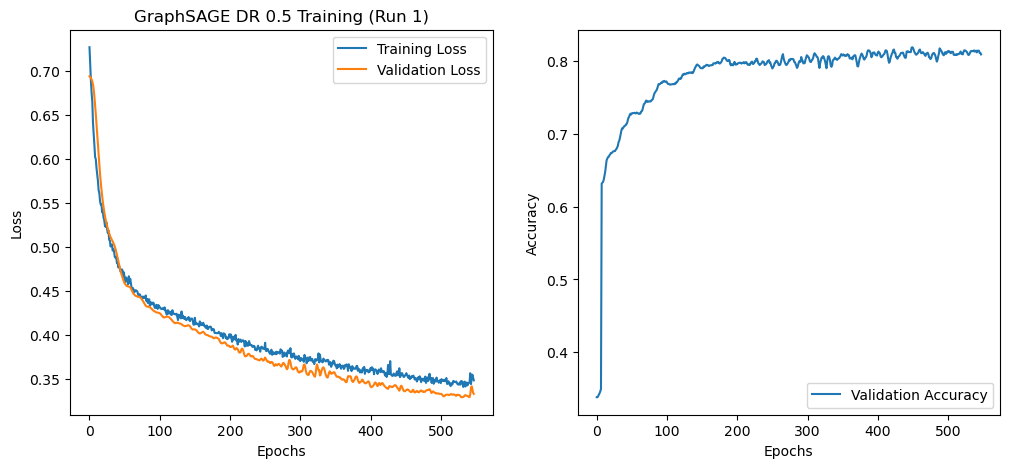


Successfully trained GraphSAGE DR 0.5 model (4/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE DR 0.7 model (5/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE DR 0.7 (Early stop):  89%|████████▉ | 894/1000 [08:25<00:59,  1.77it/s]


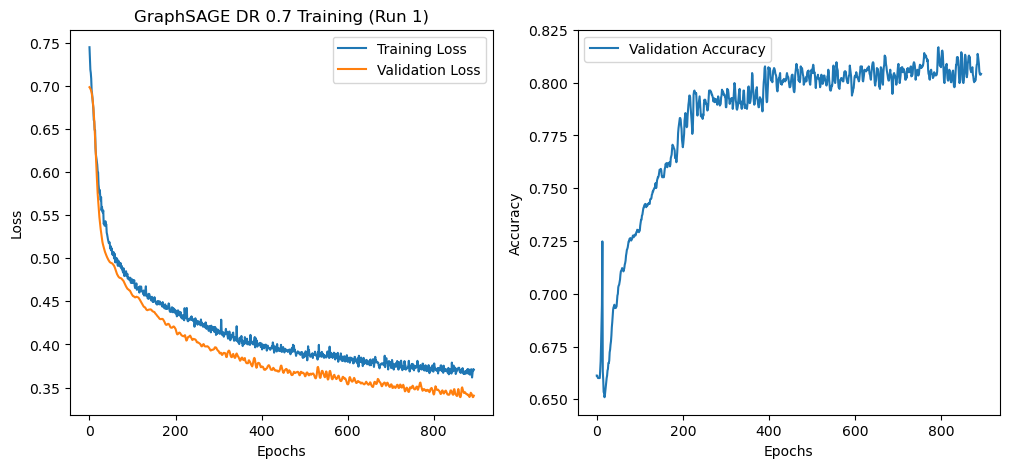


Successfully trained GraphSAGE DR 0.7 model (5/5) on chrome-run-01-without-centrality-metrics dataset


In [33]:
trained_models_dropout_rates = train_model.train_validate(models_dropout_rates, csv_file_hyperparameters, num_runs=1, print_epochs=False)

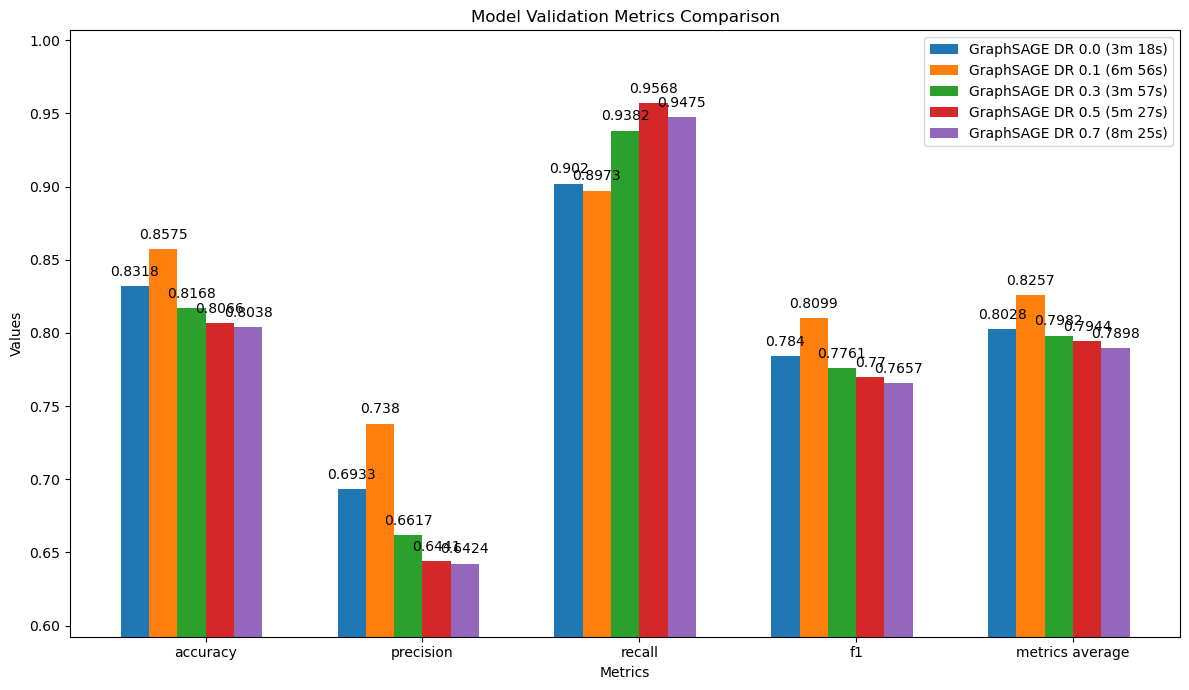

Standard Deviation for Accuracy: 0.020
Standard Deviation for Precision: 0.036
Standard Deviation for Recall: 0.024
Standard Deviation for F1: 0.016


In [34]:
evaluate_model.plot_val_metrics(trained_models_dropout_rates)

### Weight Decay

In [35]:
learning_rate = 0.001
dropout_rate = 0.1

models_weight_decays = [
    {'model_name': 'GraphSAGE WD 5e-5', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': 5e-5, 'dropout_rate': 0.0, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE WD 1e-5', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': 1e-5, 'dropout_rate': 0.1, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE WD 5e-4', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': 5e-4, 'dropout_rate': 0.3, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE WD 1e-4', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': 1e-4, 'dropout_rate': 0.5, 'criterion': cross_entropy},
    {'model_name': 'GraphSAGE WD 5e-3', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': 5e-3, 'dropout_rate': 0.7, 'criterion': cross_entropy}
]


Training GraphSAGE WD 5e-5 model (1/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE WD 5e-5 (Early stop):  32%|███▏      | 318/1000 [02:25<05:11,  2.19it/s]


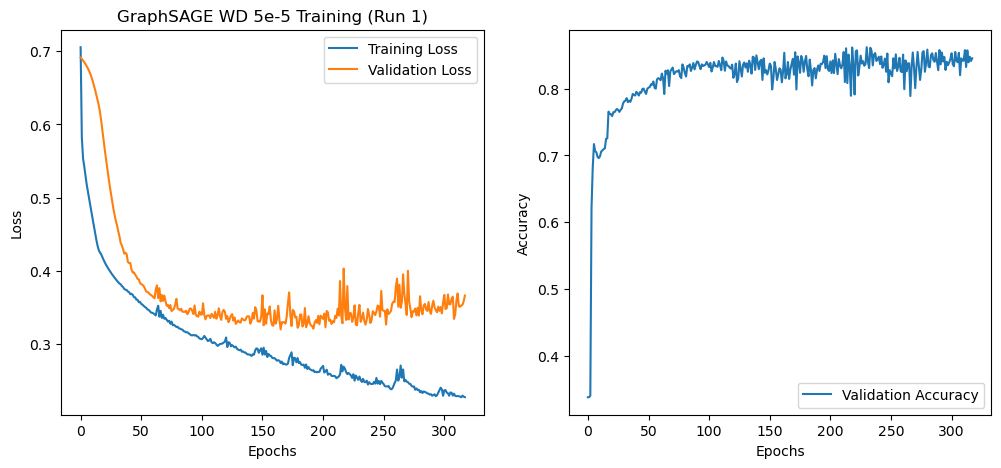


Successfully trained GraphSAGE WD 5e-5 model (1/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE WD 1e-5 model (2/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE WD 1e-5 (Early stop):  81%|████████  | 809/1000 [07:48<01:50,  1.73it/s]


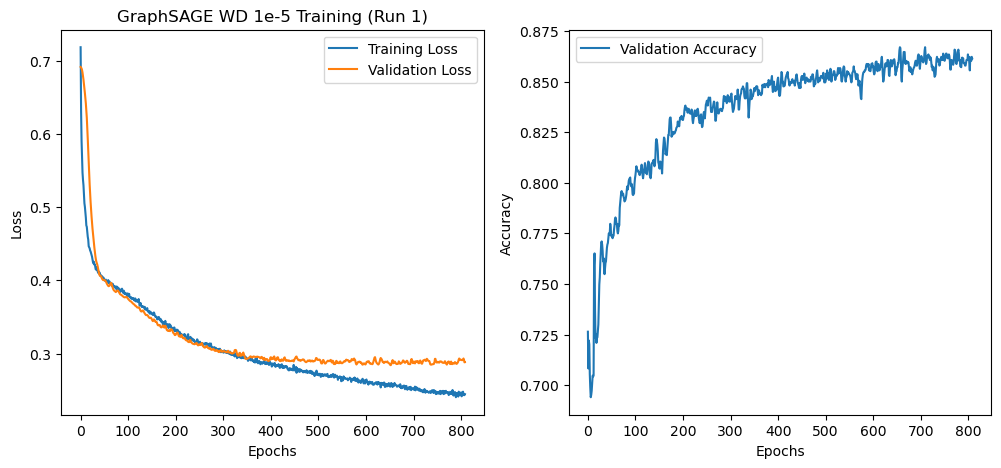


Successfully trained GraphSAGE WD 1e-5 model (2/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE WD 5e-4 model (3/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE WD 5e-4 (Early stop):  49%|████▊     | 487/1000 [04:44<04:59,  1.71it/s]


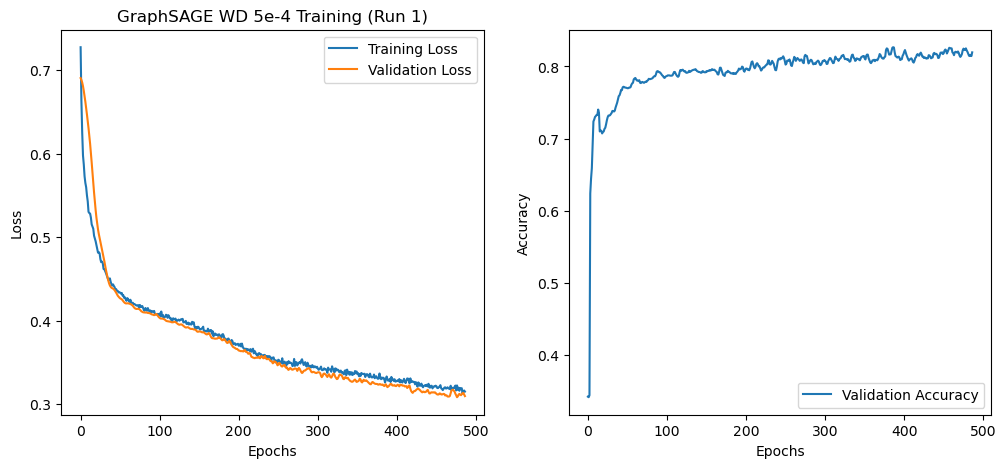


Successfully trained GraphSAGE WD 5e-4 model (3/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE WD 1e-4 model (4/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE WD 1e-4 (Early stop):  98%|█████████▊| 980/1000 [09:12<00:11,  1.77it/s]


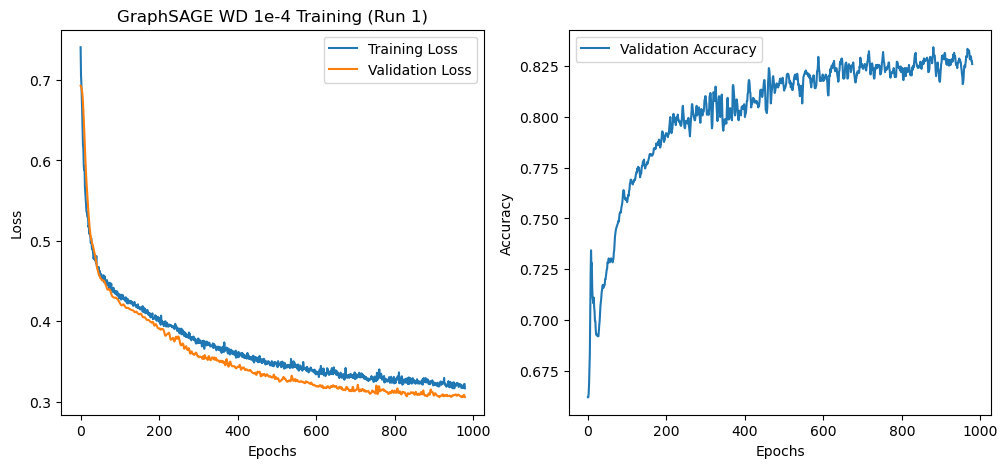


Successfully trained GraphSAGE WD 1e-4 model (4/5) on chrome-run-01-without-centrality-metrics dataset

Training GraphSAGE WD 5e-3 model (5/5) on chrome-run-01-without-centrality-metrics dataset...



Run 1/1, GraphSAGE WD 5e-3 (Early stop):  68%|██████▊   | 683/1000 [06:26<02:59,  1.77it/s]


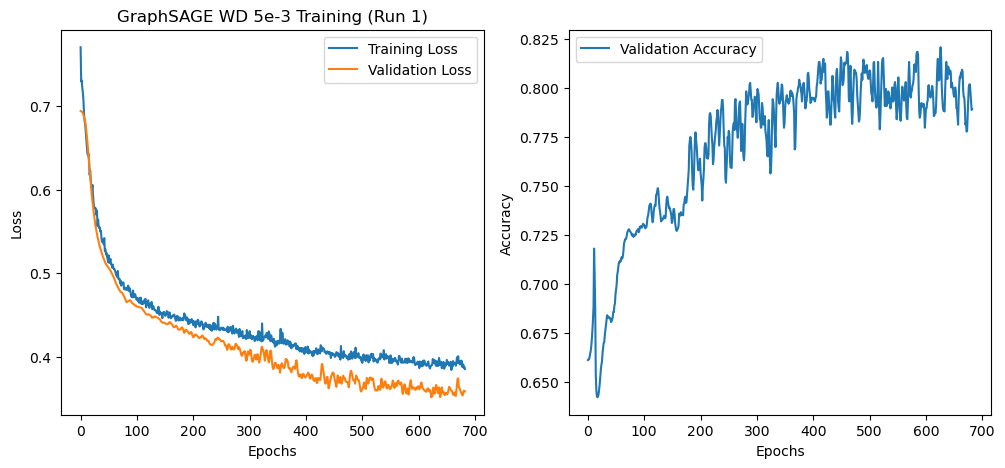


Successfully trained GraphSAGE WD 5e-3 model (5/5) on chrome-run-01-without-centrality-metrics dataset


In [36]:
trained_models_weight_decays = train_model.train_validate(models_weight_decays, csv_file_hyperparameters, num_runs=1, print_epochs=False)

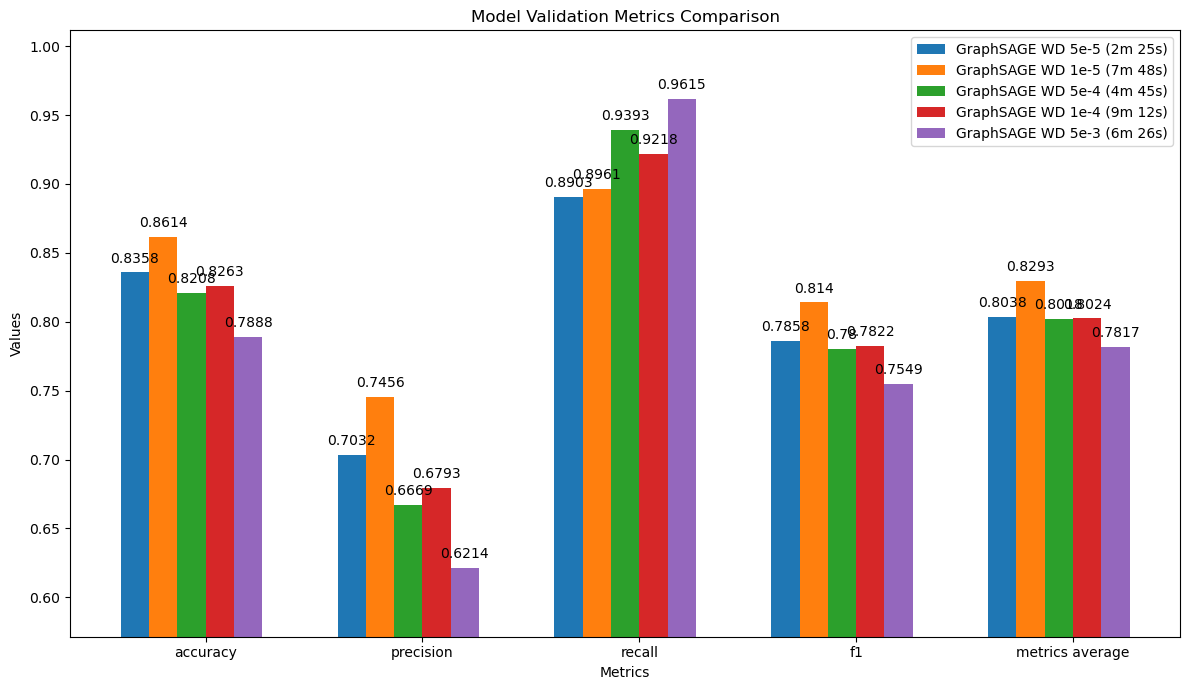

Standard Deviation for Accuracy: 0.023
Standard Deviation for Precision: 0.041
Standard Deviation for Recall: 0.027
Standard Deviation for F1: 0.019


In [37]:
evaluate_model.plot_val_metrics(trained_models_weight_decays)

### Grid Search

In [ ]:
# models = [
#     {
#         'model_name': 'GraphSAGE',
#         'model': gnn.GraphSAGE,
#         'data_name': data_name,
#         'data': data, 
#         'hidden_channels': hidden_channels,
#         'num_epochs': 500,
#         'criterion': cross_entropy
#     }
# ]

# learning_rates = [0.003, 0.005, 0.007, 0.01, 0.02]
# dropout_rates = [0.2, 0.3, 0.4, 0.5, 0.6]
# weight_decays = [5e-5, 1e-4, 2e-4, 5e-4, 1e-3]

In [38]:
# grid_search = evaluate_model.grid_search(models, csv_file_grid_search, learning_rates, dropout_rates, weight_decays, num_runs=1)

We now analyze the results of the grid search:

In [39]:
# evaluate_model.analyze_log_metrics(csv_file_grid_search)

### Bayesian Optimization

In [63]:
space = [
    Real(0.001, 0.01, name='learning_rate'),
    Real(5e-5, 5e-4, name='weight_decay'),
    Real(0.0, 0.4, name='dropout_rate'),
]

# Usage example (assuming `data`, `num_features`, and `hidden_channels` are defined and a model class `GraphSAGE` exists)
best_hyperparams = evaluate_model.optimize_hyperparameters(gnn.GraphSAGE, data, hidden_channels, space, csv_file_bayesian_opt, num_epochs=500, print_epochs=False)

Configuration 1/50 (LR:0.006335601564025167, WD:0.00042991958686145794, DR:0.3431782470491028) (Early stop):  99%|█████████▉| 497/500 [03:59<00:01,  2.08it/s]
Configuration 2/50 (LR:0.008625265649057131, WD:0.00033060366355368764, DR:0.15375268291708) (Early stop):  71%|███████   | 356/500 [02:50<01:08,  2.09it/s]
Configuration 3/50 (LR:0.003677811458900251, WD:7.552083979284945e-05, DR:0.1090625178320453) (Early stop):  69%|██████▉   | 346/500 [02:45<01:13,  2.09it/s]
Configuration 4/50 (LR:0.005298986055892151, WD:0.00041547592794897206, DR:0.19199086895002299) (Early stop):  67%|██████▋   | 334/500 [02:40<01:19,  2.08it/s]
Configuration 5/50 (LR:0.0045350631649074685, WD:0.00042623544359182003, DR:0.13495846416690738): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
Configuration 6/50 (LR:0.006833546848460777, WD:0.0002157086929282466, DR:0.38286206358121866): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
Configuration 7/50 (LR:0.002263157023713807, WD:0.0004415392662612965, D

Best hyperparameters:  [0.0058707349816293514, 0.0001303265185661174, 0.08585975801098884]
